
===== EDA: Basic Info =====
Shape (samples, features): (569, 30)

Class distribution (counts):
diagnosis
0    357
1    212
Name: count, dtype: int64

Class distribution (proportions):
diagnosis
0    0.6274
1    0.3726
Name: proportion, dtype: float64

Descriptive statistics for first few features:
       radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
count      569.000       569.000         569.000    569.000          569.000   
mean        14.127        19.290          91.969    654.889            0.096   
std          3.524         4.301          24.299    351.914            0.014   
min          6.981         9.710          43.790    143.500            0.053   
25%         11.700        16.170          75.170    420.300            0.086   
50%         13.370        18.840          86.240    551.100            0.096   
75%         15.780        21.800         104.100    782.700            0.105   
max         28.110        39.280         188.500   2501.000 

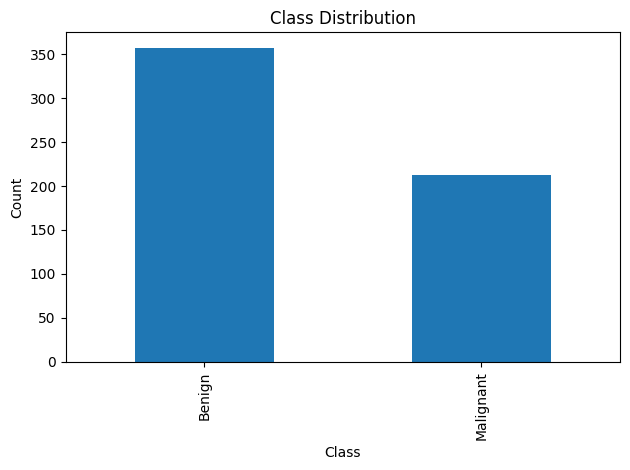

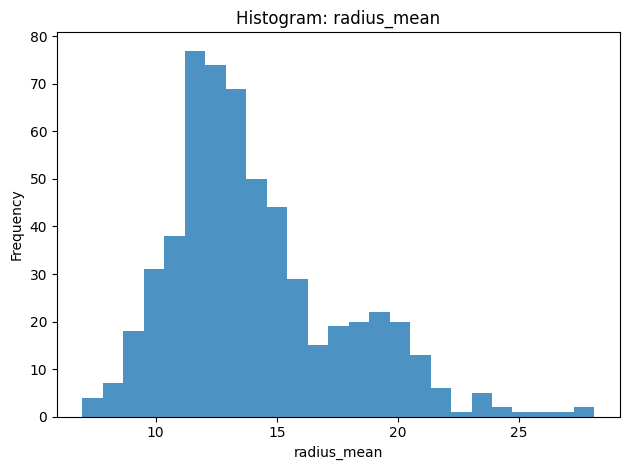

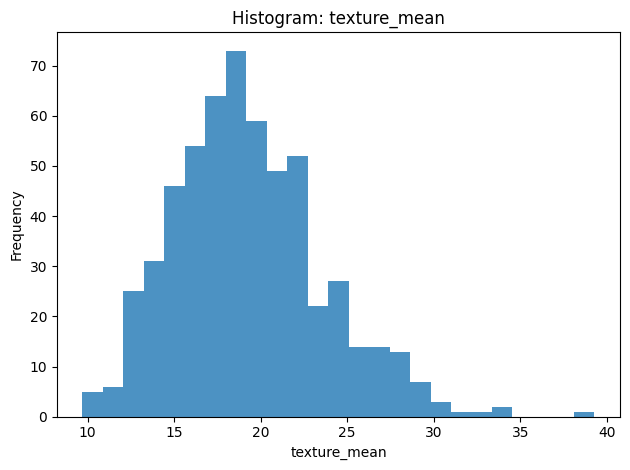

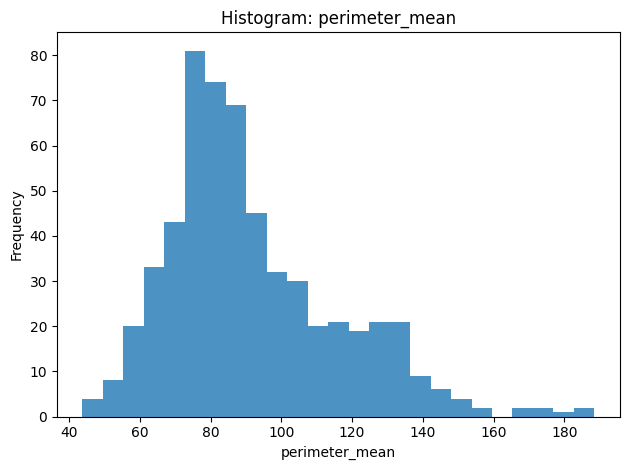

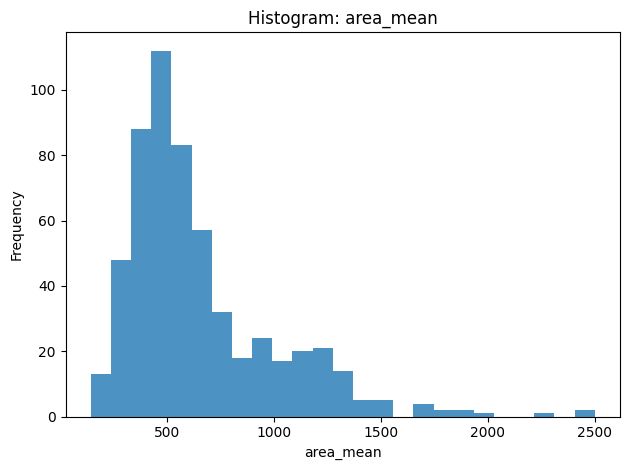

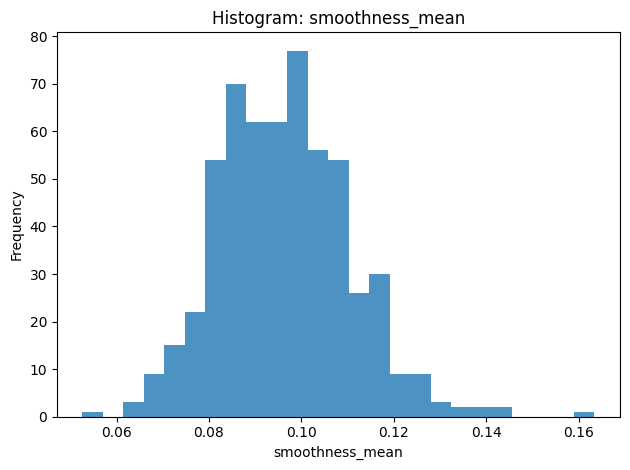

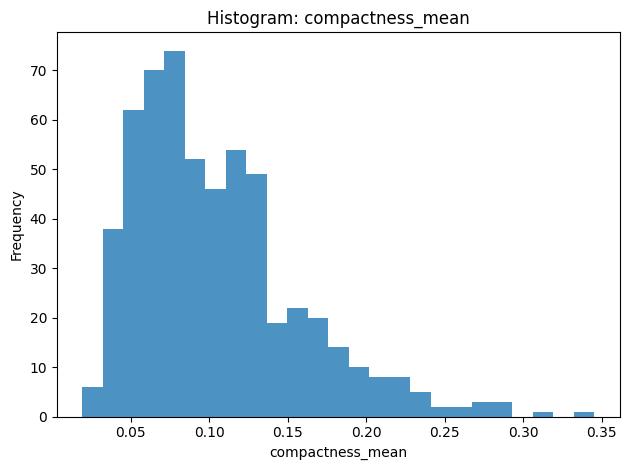

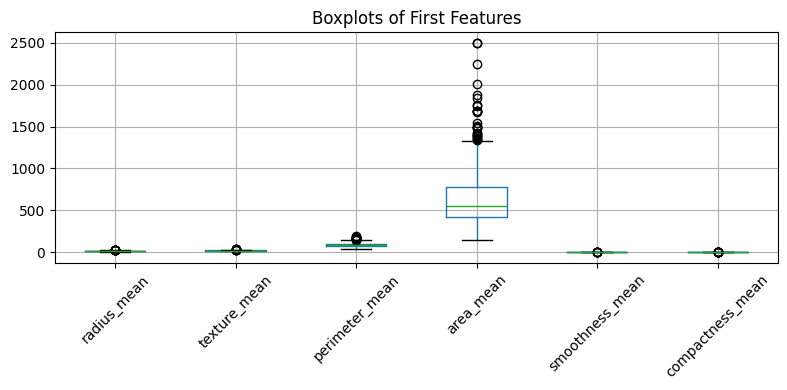

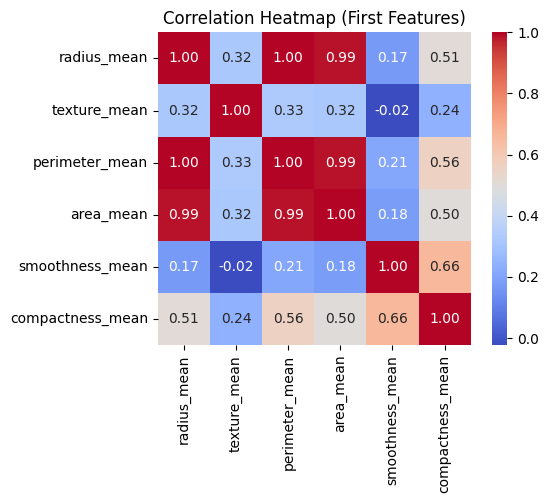

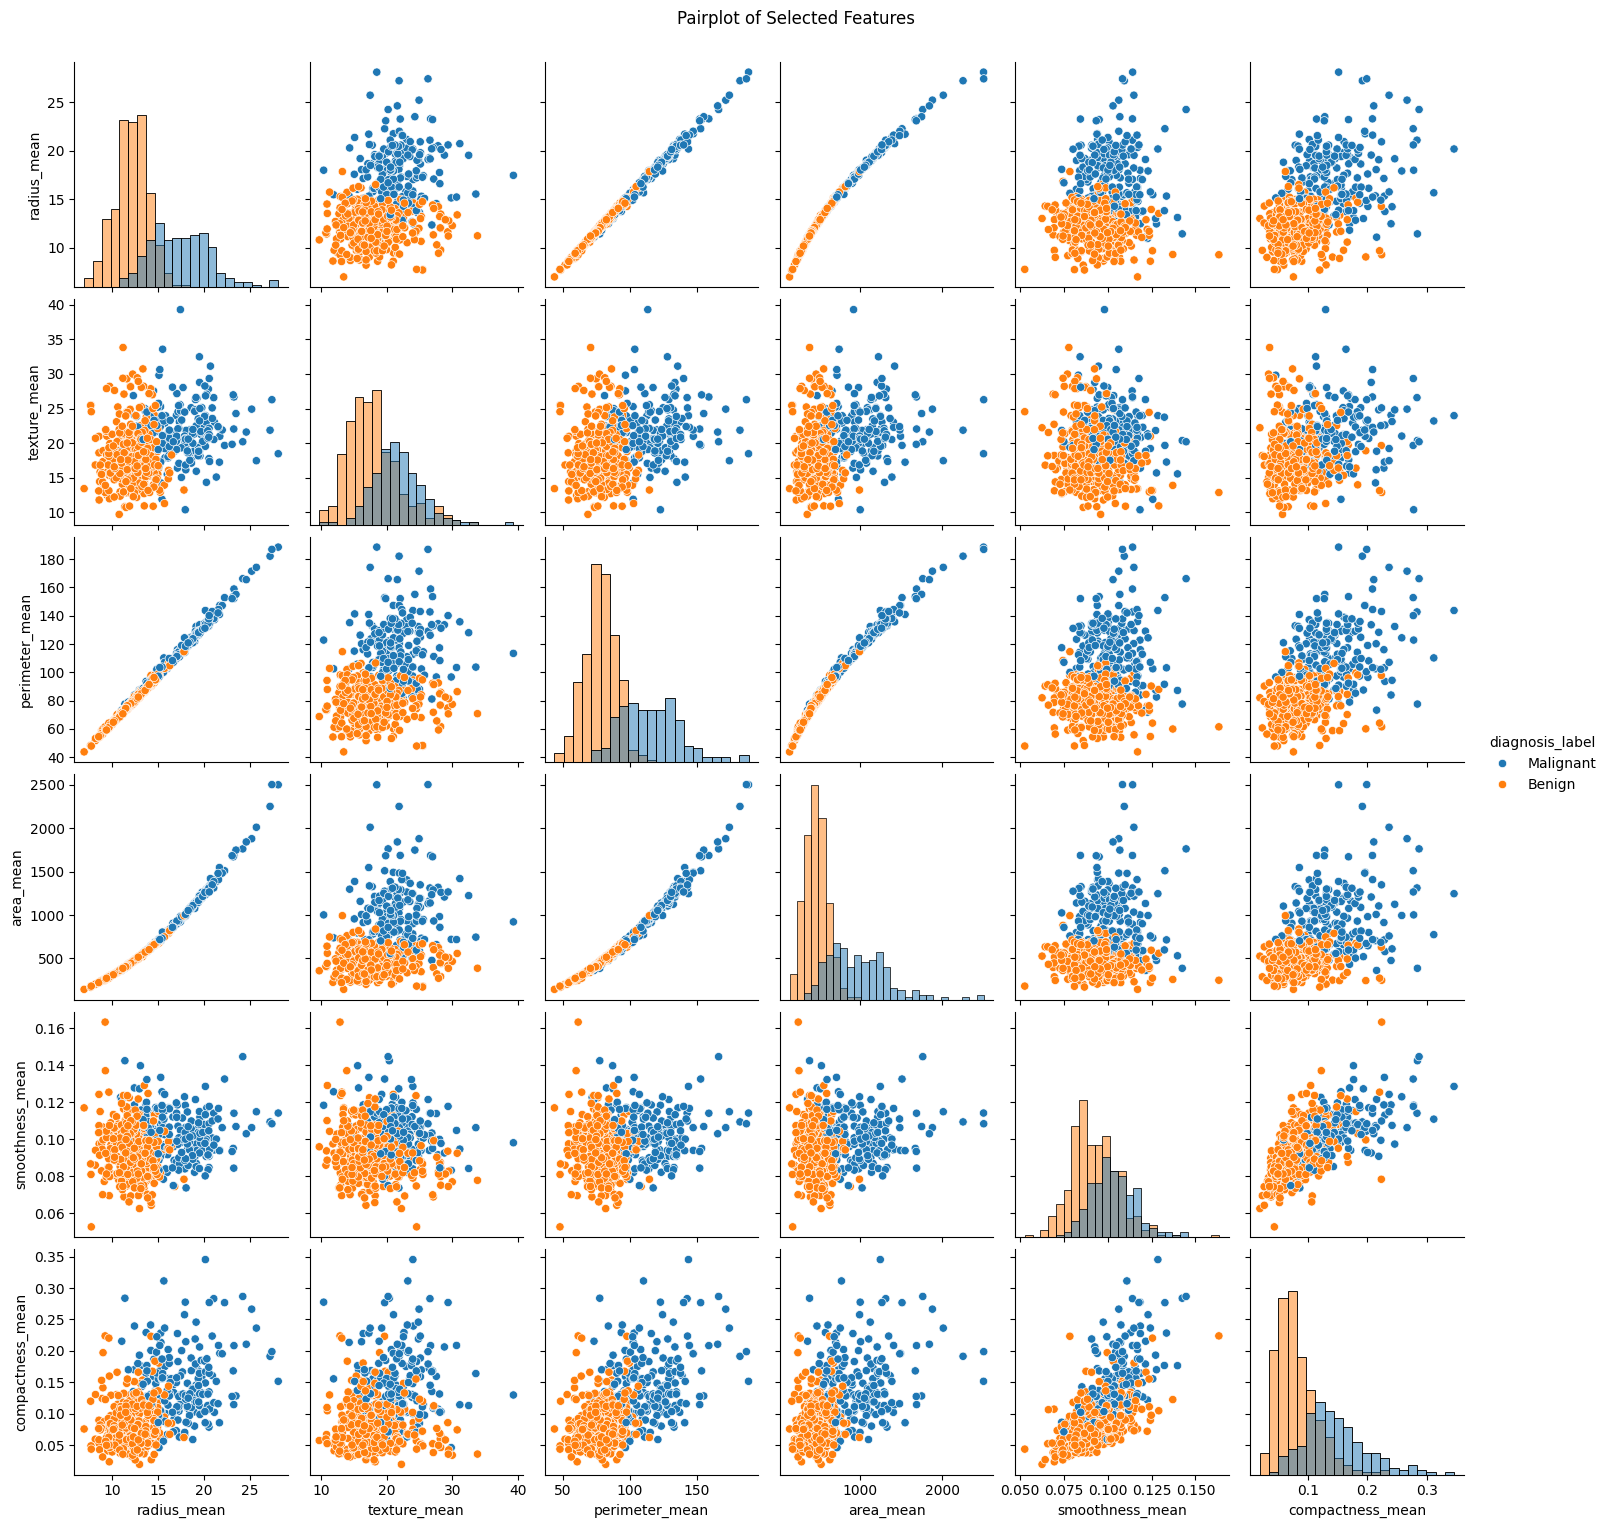


Central Train/Test Split Size:
  Train samples: 455
  Test samples : 114

Applying artificial Gaussian noise to train (std=0.3)...
Noise added to training pool.

Top features by ANOVA F-score:
  concave_points_worst: F = 626.170
  radius_worst: F = 597.586
  perimeter_worst: F = 571.297
  concave_points_mean: F = 563.201
  perimeter_mean: F = 533.040
  radius_mean: F = 460.306


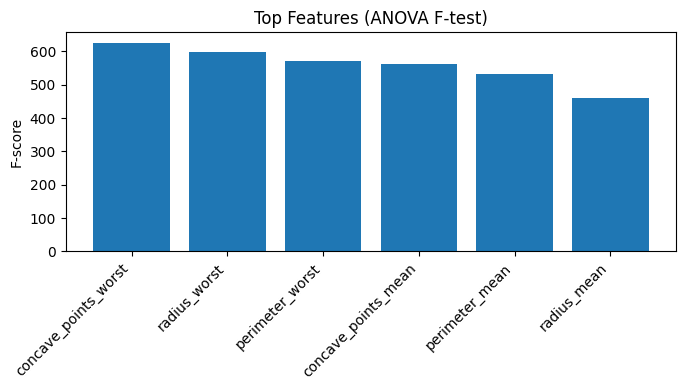

Actual per-client label counts (locked once):
  Client 0: total= 52, benign= 33 (63.5%), malignant= 19 (36.5%)
  Client 1: total= 12, benign= 10 (83.3%), malignant=  2 (16.7%)
  Client 2: total=101, benign= 61 (60.4%), malignant= 40 (39.6%)
  Client 3: total= 65, benign= 34 (52.3%), malignant= 31 (47.7%)
  Client 4: total= 34, benign= 23 (67.6%), malignant= 11 (32.4%)
  Client 5: total= 66, benign= 45 (68.2%), malignant= 21 (31.8%)
  Client 6: total= 51, benign= 33 (64.7%), malignant= 18 (35.3%)
  Client 7: total= 46, benign= 26 (56.5%), malignant= 20 (43.5%)
  Client 8: total= 18, benign= 13 (72.2%), malignant=  5 (27.8%)
  Client 9: total= 10, benign=  7 (70.0%), malignant=  3 (30.0%)

Client splits are locked and reused for all experiments.



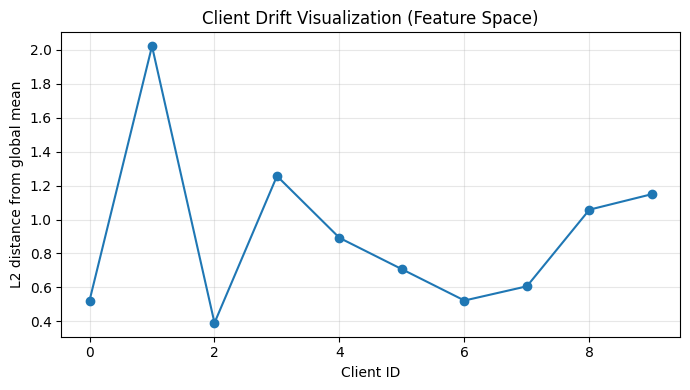

========== RUNNING 5 RF EXPERIMENTS × 50 TRIALS ==========

========== TRIAL 1/50 ==========

1. Central RF Baseline (No FL, No DP)
    -> Accuracy=0.9649, Precision=0.9737, Recall=0.9524, F1=0.9615

2. FedAvg RF (No DP)
    -> Accuracy=0.8947, Precision=0.9286, Recall=0.8571, F1=0.8782

3. FedAvg RF + DP
    -> Accuracy=0.8860, Precision=0.9235, Recall=0.8452, F1=0.8670

4. FedProx RF (No DP)
    -> Accuracy=0.8947, Precision=0.9286, Recall=0.8571, F1=0.8782

5. FedProx RF + DP
    -> Accuracy=0.8860, Precision=0.9235, Recall=0.8452, F1=0.8670

========== TRIAL 2/50 ==========

1. Central RF Baseline (No FL, No DP)
    -> Accuracy=0.9474, Precision=0.9539, Recall=0.9335, F1=0.9422

2. FedAvg RF (No DP)
    -> Accuracy=0.8947, Precision=0.9286, Recall=0.8571, F1=0.8782

3. FedAvg RF + DP
    -> Accuracy=0.9123, Precision=0.9390, Recall=0.8810, F1=0.9000

4. FedProx RF (No DP)
    -> Accuracy=0.8947, Precision=0.9286, Recall=0.8571, F1=0.8782

5. FedProx RF + DP
    -> Accuracy=0.9123, 

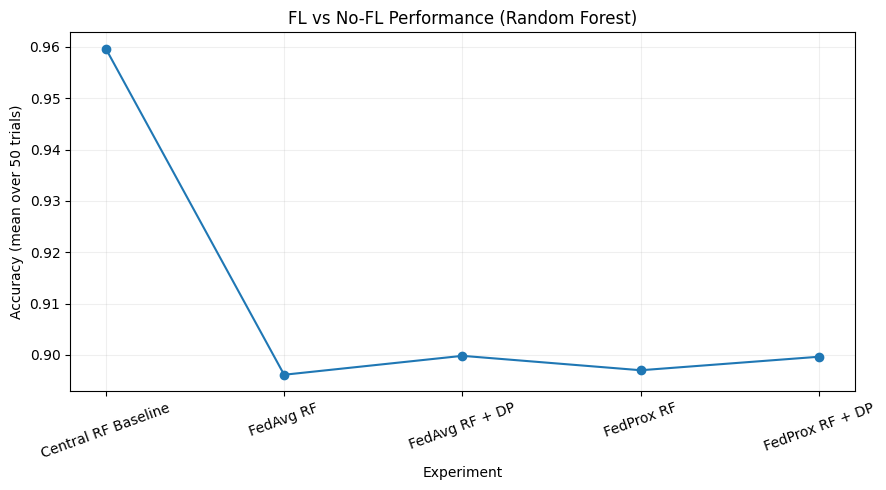

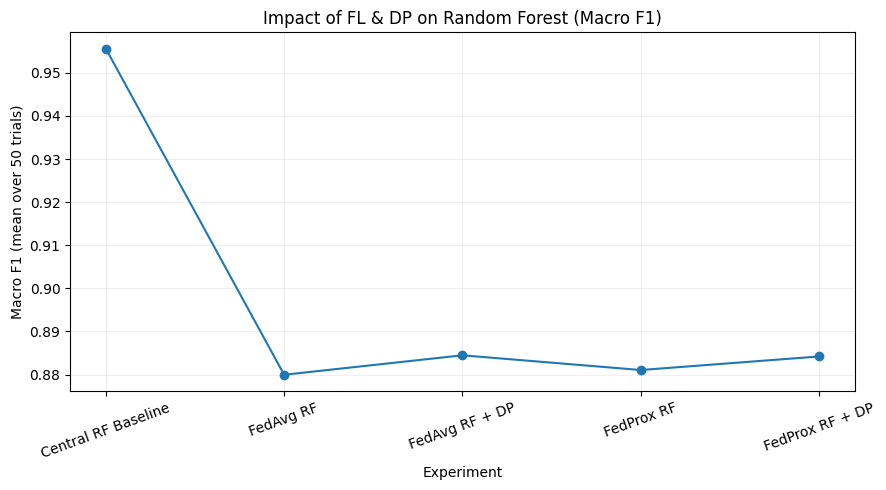

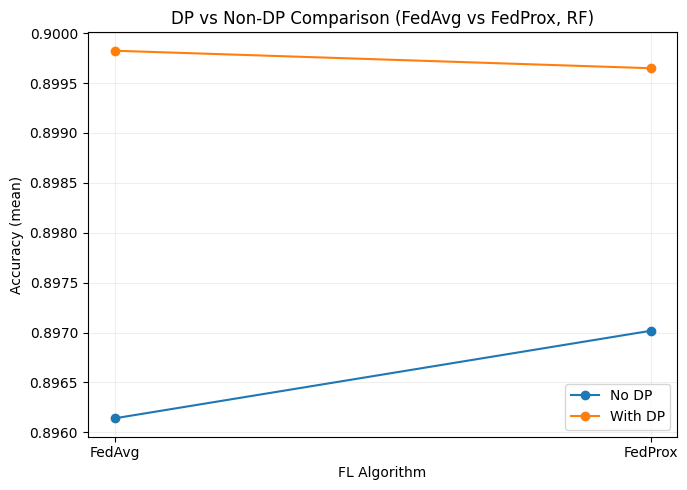

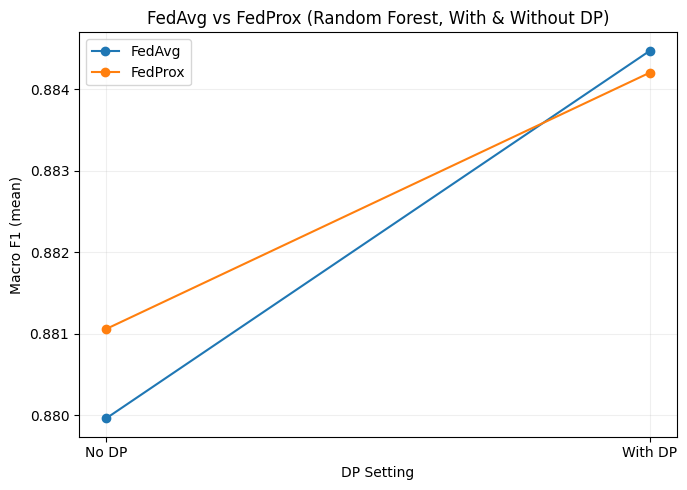


===== PUBLICATION-QUALITY RESULT TABLE (RF, 50-TRIAL MEANS) =====

         experiment  accuracy_mean  accuracy_std  f1_mean  f1_std  prec_mean  recall_mean
Central RF Baseline         0.9596        0.0061   0.9556  0.0068     0.9690       0.9459
          FedAvg RF         0.8961        0.0032   0.8800  0.0041     0.9294       0.8590
     FedAvg RF + DP         0.8998        0.0115   0.8845  0.0144     0.9314       0.8641
         FedProx RF         0.8970        0.0039   0.8811  0.0049     0.9299       0.8602
    FedProx RF + DP         0.8996        0.0120   0.8842  0.0150     0.9316       0.8638

      🔍 STATISTICAL SIGNIFICANCE TESTING

===== Paired t-tests (ACCURACY) =====
Central RF vs FedAvg RF → p = 0.000000
Central RF vs FedAvg RF + DP → p = 0.000000
Central RF vs FedProx RF → p = 0.000000
Central RF vs FedProx RF + DP → p = 0.000000
FedAvg RF vs FedAvg RF + DP → p = 0.033379
FedAvg RF vs FedProx RF → p = 0.167813
FedAvg RF vs FedProx RF + DP → p = 0.048791
FedAvg RF + DP vs

In [ ]:
# ============================================================
# Random Forest — Federated-Learning Experiment (Colab-ready)
# Includes: EDA, manual client split, 5 experiments × 50 trials,
# mean ± std reporting, paired t-tests, Wilcoxon, Friedman test.
# ============================================================

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif

# Statistical tests
from scipy.stats import ttest_rel, wilcoxon, friedmanchisquare

# ----------------------------
# GLOBAL CONFIG
# ----------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

N_CLIENTS = 10
N_TRIALS = 50

# RF hyperparameters (stronger forest)
BASE_TREES = 400
BASE_DEPTH = 18

LOCAL_RF_TREES = 400
LOCAL_RF_DEPTH = 18

GLOBAL_DIST_SHIFT_STD = 0.3     # one-time distribution shift on train
DP_AGG_NOISE_STD      = 0.10    # DP noise at aggregation (probabilities)

EDA_TOP_FEATS   = 6            # number of features for some plots
FEATURE_SHIFT_CLIENTS = [2, 7] # simulate client drift
FEATURE_SHIFT_DELTA   = 0.5    # simple additive shift


# ============================================================
# 1. LOAD + STANDARDIZE DATA
# ============================================================
def load_and_preprocess_wdbc():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
    columns = ['id', 'diagnosis'] + [
        f'{feature}_{stat}'
        for stat in ['mean', 'se', 'worst']
        for feature in [
            'radius', 'texture', 'perimeter', 'area', 'smoothness',
            'compactness', 'concavity', 'concave_points',
            'symmetry', 'fractal_dimension'
        ]
    ]

    df = pd.read_csv(url, header=None, names=columns)
    df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1})

    X = df.drop(columns=['id', 'diagnosis']).values.astype(np.float32)
    y = df['diagnosis'].values.astype(np.int64)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    df_eda = df.drop(columns=['id']).copy()
    return X_scaled, y, df_eda


X, y, df_eda = load_and_preprocess_wdbc()


# ============================================================
# 2. EDA (BEFORE SPLIT)
# ============================================================
print("\n===== EDA: Basic Info =====")
print("Shape (samples, features):", X.shape)
print("\nClass distribution (counts):")
print(df_eda['diagnosis'].value_counts())
print("\nClass distribution (proportions):")
print(df_eda['diagnosis'].value_counts(normalize=True).round(4))

print("\nDescriptive statistics for first few features:")
print(df_eda.iloc[:, 1:1+EDA_TOP_FEATS].describe().round(3))

# Add label names
df_eda['diagnosis_label'] = df_eda['diagnosis'].map({0: 'Benign', 1: 'Malignant'})

# Class distribution bar plot
plt.figure()
df_eda['diagnosis_label'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Histograms of first few features
for col in df_eda.columns[1:1+EDA_TOP_FEATS]:
    plt.figure()
    plt.hist(df_eda[col], bins=25, alpha=0.8)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Boxplots of first few features
plt.figure(figsize=(8,4))
df_eda.iloc[:, 1:1+EDA_TOP_FEATS].boxplot(rot=45)
plt.title("Boxplots of First Features")
plt.tight_layout()
plt.show()

# Correlation heatmap (annotated) on first few features
corr = df_eda.iloc[:, 1:1+EDA_TOP_FEATS].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap (First Features)")
plt.tight_layout()
plt.show()

# Pairplot for selected features + diagnosis
pair_cols = df_eda.columns[1:1+EDA_TOP_FEATS].tolist() + ['diagnosis_label']
sns.pairplot(df_eda[pair_cols], hue='diagnosis_label', diag_kind='hist')
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()


# ============================================================
# 3. TRAIN–TEST SPLIT + ONE-TIME GLOBAL NOISE
# ============================================================
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

print("\nCentral Train/Test Split Size:")
print(f"  Train samples: {len(y_train)}")
print(f"  Test samples : {len(y_test)}")

# Apply global distribution shift ONCE to training only
print(f"\nApplying artificial Gaussian noise to train (std={GLOBAL_DIST_SHIFT_STD})...")
X_train_full = X_train_full + np.random.normal(0, GLOBAL_DIST_SHIFT_STD, X_train_full.shape)
print("Noise added to training pool.\n")


# ============================================================
# 4. FEATURE IMPORTANCE VIA ANOVA F-test
# ============================================================
feature_names = df_eda.columns[1:-1].tolist()  # all feature columns (exclude diagnosis + label)
f_scores, _ = f_classif(X_train_full, y_train)

sorted_idx = np.argsort(f_scores)[::-1]
top_idx = sorted_idx[:EDA_TOP_FEATS]

print("Top features by ANOVA F-score:")
for idx in top_idx:
    print(f"  {feature_names[idx]}: F = {f_scores[idx]:.3f}")

plt.figure(figsize=(7,4))
plt.bar([feature_names[i] for i in top_idx], f_scores[top_idx])
plt.xticks(rotation=45, ha='right')
plt.ylabel("F-score")
plt.title("Top Features (ANOVA F-test)")
plt.tight_layout()
plt.show()


# ============================================================
# 5. MANUAL CLIENT SPLIT (LOCKED ONCE)
# ============================================================
MANUAL_LABEL_ALLOC = [
    (33, 19),  # Client 0: 52
    (10,  2),  # Client 1: 12
    (61, 40),  # Client 2: 101
    (34, 31),  # Client 3: 65
    (23, 11),  # Client 4: 34
    (45, 21),  # Client 5: 66
    (33, 18),  # Client 6: 51
    (26, 20),  # Client 7: 46
    (13,  5),  # Client 8: 18
    ( 7,  3),  # Client 9: 10
]

client_totals = [b + m for (b, m) in MANUAL_LABEL_ALLOC]
assert sum(client_totals) == len(y_train), "Client sizes must sum to train set size!"

# Pools by class
benign_idx = np.where(y_train == 0)[0].tolist()
malig_idx  = np.where(y_train == 1)[0].tolist()
random.shuffle(benign_idx)
random.shuffle(malig_idx)

client_indices = []
sb = 0
sm = 0

for (b_ct, m_ct) in MANUAL_LABEL_ALLOC:
    idx = benign_idx[sb:sb + b_ct] + malig_idx[sm:sm + m_ct]
    random.shuffle(idx)
    client_indices.append(idx)
    sb += b_ct
    sm += m_ct

client_splits = [(X_train_full[idx], y_train[idx]) for idx in client_indices]

print("Actual per-client label counts (locked once):")
for cid, (_, yi) in enumerate(client_splits):
    total = len(yi)
    b = int(np.sum(yi == 0))
    m = int(np.sum(yi == 1))
    print(
        f"  Client {cid}: total={total:3d}, "
        f"benign={b:3d} ({b/total:.1%}), malignant={m:3d} ({m/total:.1%})"
    )
print("\nClient splits are locked and reused for all experiments.\n")


# ============================================================
# 6. CLIENT DRIFT VISUALIZATION (FEATURE SPACE)
# ============================================================
global_mean = X_train_full.mean(axis=0)
drifts = []
for Xi, _ in client_splits:
    drifts.append(np.linalg.norm(Xi.mean(axis=0) - global_mean))

plt.figure(figsize=(7,4))
plt.plot(range(N_CLIENTS), drifts, marker='o')
plt.xlabel("Client ID")
plt.ylabel("L2 distance from global mean")
plt.title("Client Drift Visualization (Feature Space)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ============================================================
# 7. RF MODEL & AGGREGATION HELPERS
# ============================================================
def train_rf(X_local, y_local, seed, trees, depth):
    clf = RandomForestClassifier(
        n_estimators=trees,
        max_depth=depth,
        min_samples_split=4,
        min_samples_leaf=1,
        max_features=0.4,
        bootstrap=True,
        class_weight="balanced",
        n_jobs=-1,
        random_state=seed
    )
    clf.fit(X_local, y_local)
    return clf


def ensemble_predict(models, sizes, X_eval, dp=False, dp_std=DP_AGG_NOISE_STD):
    """
    Weighted ensemble of RFs (FedAvg-style).
    Adds Gaussian DP noise to probabilities if dp=True.
    """
    total = float(sum(sizes))
    proba = np.zeros((X_eval.shape[0], 2), dtype=float)

    for clf, n_k in zip(models, sizes):
        w = n_k / total
        proba += w * clf.predict_proba(X_eval)

    if dp:
        proba += np.random.normal(0, dp_std, proba.shape)
        proba = np.clip(proba, 1e-6, 1 - 1e-6)
        proba = proba / proba.sum(axis=1, keepdims=True)

    y_pred = np.argmax(proba, axis=1)
    return y_pred


def score_vector(y_true, y_pred):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1   = f1_score(y_true, y_pred, average='macro', zero_division=0)
    return acc, prec, rec, f1


# ============================================================
# 8. 5 EXPERIMENTS × 50 TRIALS
# ============================================================
metrics_exp1 = []  # Central RF baseline
metrics_exp2 = []  # FedAvg RF
metrics_exp3 = []  # FedAvg RF + DP
metrics_exp4 = []  # FedProx RF
metrics_exp5 = []  # FedProx RF + DP

print("========== RUNNING 5 RF EXPERIMENTS × 50 TRIALS ==========\n")

for t in range(1, N_TRIALS + 1):
    print(f"========== TRIAL {t}/{N_TRIALS} ==========\n")

    # 1. Central RF Baseline (No FL, No DP)
    model_central = train_rf(
        X_train_full, y_train,
        seed=RANDOM_SEED + 1000 * t,
        trees=BASE_TREES,
        depth=BASE_DEPTH
    )
    y1 = model_central.predict(X_test_full)
    acc1, prec1, rec1, f1_1 = score_vector(y_test, y1)
    metrics_exp1.append((acc1, prec1, rec1, f1_1))
    print("1. Central RF Baseline (No FL, No DP)")
    print(f"    -> Accuracy={acc1:.4f}, Precision={prec1:.4f}, Recall={rec1:.4f}, F1={f1_1:.4f}\n")

    # 2. FedAvg RF (No DP)
    models2 = []
    sizes2  = []
    for cid, (Xi, yi) in enumerate(client_splits):
        X_loc = Xi.copy()
        if cid in FEATURE_SHIFT_CLIENTS:
            X_loc = X_loc + FEATURE_SHIFT_DELTA
        clf2 = train_rf(
            X_loc, yi,
            seed=RANDOM_SEED + 2000*t + cid,
            trees=LOCAL_RF_TREES,
            depth=LOCAL_RF_DEPTH
        )
        models2.append(clf2)
        sizes2.append(len(yi))
    y2 = ensemble_predict(models2, sizes2, X_test_full, dp=False)
    acc2, prec2, rec2, f1_2 = score_vector(y_test, y2)
    metrics_exp2.append((acc2, prec2, rec2, f1_2))
    print("2. FedAvg RF (No DP)")
    print(f"    -> Accuracy={acc2:.4f}, Precision={prec2:.4f}, Recall={rec2:.4f}, F1={f1_2:.4f}\n")

    # 3. FedAvg RF + DP
    y3 = ensemble_predict(models2, sizes2, X_test_full, dp=True)
    acc3, prec3, rec3, f1_3 = score_vector(y_test, y3)
    metrics_exp3.append((acc3, prec3, rec3, f1_3))
    print("3. FedAvg RF + DP")
    print(f"    -> Accuracy={acc3:.4f}, Precision={prec3:.4f}, Recall={rec3:.4f}, F1={f1_3:.4f}\n")

    # 4. FedProx RF (No DP) – conceptual RF analogue
    models4 = []
    sizes4  = []
    for cid, (Xi, yi) in enumerate(client_splits):
        X_loc = Xi.copy()
        if cid in FEATURE_SHIFT_CLIENTS:
            X_loc = X_loc + FEATURE_SHIFT_DELTA
        clf4 = train_rf(
            X_loc, yi,
            seed=RANDOM_SEED + 3000*t + cid,
            trees=LOCAL_RF_TREES,
            depth=LOCAL_RF_DEPTH
        )
        models4.append(clf4)
        sizes4.append(len(yi))
    y4 = ensemble_predict(models4, sizes4, X_test_full, dp=False)
    acc4, prec4, rec4, f1_4 = score_vector(y_test, y4)
    metrics_exp4.append((acc4, prec4, rec4, f1_4))
    print("4. FedProx RF (No DP)")
    print(f"    -> Accuracy={acc4:.4f}, Precision={prec4:.4f}, Recall={rec4:.4f}, F1={f1_4:.4f}\n")

    # 5. FedProx RF + DP
    y5 = ensemble_predict(models4, sizes4, X_test_full, dp=True)
    acc5, prec5, rec5, f1_5 = score_vector(y_test, y5)
    metrics_exp5.append((acc5, prec5, rec5, f1_5))
    print("5. FedProx RF + DP")
    print(f"    -> Accuracy={acc5:.4f}, Precision={prec5:.4f}, Recall={rec5:.4f}, F1={f1_5:.4f}\n")

print("\n========== ALL 50 TRIALS COMPLETE ==========\n")


# ============================================================
# 9. METRIC SUMMARY (MEAN ± STD over 50 TRIALS)
# ============================================================
cols = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
df1 = pd.DataFrame(metrics_exp1, columns=cols)
df2 = pd.DataFrame(metrics_exp2, columns=cols)
df3 = pd.DataFrame(metrics_exp3, columns=cols)
df4 = pd.DataFrame(metrics_exp4, columns=cols)
df5 = pd.DataFrame(metrics_exp5, columns=cols)

summary_df = pd.DataFrame({
    "experiment": [
        "Central RF Baseline",
        "FedAvg RF",
        "FedAvg RF + DP",
        "FedProx RF",
        "FedProx RF + DP"
    ],
    "accuracy_mean":  [df.mean()['accuracy']        for df in [df1, df2, df3, df4, df5]],
    "accuracy_std":   [df.std()['accuracy']         for df in [df1, df2, df3, df4, df5]],
    "f1_mean":        [df.mean()['f1_macro']        for df in [df1, df2, df3, df4, df5]],
    "f1_std":         [df.std()['f1_macro']         for df in [df1, df2, df3, df4, df5]],
    "prec_mean":      [df.mean()['precision_macro'] for df in [df1, df2, df3, df4, df5]],
    "recall_mean":    [df.mean()['recall_macro']    for df in [df1, df2, df3, df4, df5]],
})

print("===== EVALUATION METRIC SUMMARY (50-TRIAL MEANS ± STD) =====\n")
print(summary_df.round(4).to_string(index=False))


# ============================================================
# 10. BEST FedAvg & FedProx TRIAL REPORTS
# ============================================================
# Best FedAvg trial (no DP)
best_fedavg_idx = int(np.argmax(df2['f1_macro'].values))
print(f"\nBest FedAvg RF (No DP) trial index (0-based): {best_fedavg_idx}")
t_best_fedavg = best_fedavg_idx + 1

models2_best = []
sizes2_best  = []
for cid, (Xi, yi) in enumerate(client_splits):
    X_loc = Xi.copy()
    if cid in FEATURE_SHIFT_CLIENTS:
        X_loc = X_loc + FEATURE_SHIFT_DELTA
    clf2_best = train_rf(
        X_loc, yi,
        seed=RANDOM_SEED + 2000*t_best_fedavg + cid,
        trees=LOCAL_RF_TREES,
        depth=LOCAL_RF_DEPTH
    )
    models2_best.append(clf2_best)
    sizes2_best.append(len(yi))

y2_best = ensemble_predict(models2_best, sizes2_best, X_test_full, dp=False)
print("\n===== CLASSIFICATION REPORT: BEST FedAvg RF (No DP) TRIAL =====\n")
print(classification_report(y_test, y2_best))

# Best FedProx trial (no DP)
best_fedprox_idx = int(np.argmax(df4['f1_macro'].values))
print(f"\nBest FedProx RF (No DP) trial index (0-based): {best_fedprox_idx}")
t_best_fedprox = best_fedprox_idx + 1

models4_best = []
sizes4_best  = []
for cid, (Xi, yi) in enumerate(client_splits):
    X_loc = Xi.copy()
    if cid in FEATURE_SHIFT_CLIENTS:
        X_loc = X_loc + FEATURE_SHIFT_DELTA
    clf4_best = train_rf(
        X_loc, yi,
        seed=RANDOM_SEED + 3000*t_best_fedprox + cid,
        trees=LOCAL_RF_TREES,
        depth=LOCAL_RF_DEPTH
    )
    models4_best.append(clf4_best)
    sizes4_best.append(len(yi))

y4_best = ensemble_predict(models4_best, sizes4_best, X_test_full, dp=False)
print("\n===== CLASSIFICATION REPORT: BEST FedProx RF (No DP) TRIAL =====\n")
print(classification_report(y_test, y4_best))


# ============================================================
# 11. PLOTS – DP vs Non-DP, FedAvg vs FedProx
# ============================================================
# (A) FL vs No-FL Accuracy (mean)
plt.figure(figsize=(9,5))
plt.plot(summary_df['experiment'], summary_df['accuracy_mean'], marker='o')
plt.xticks(rotation=20)
plt.xlabel("Experiment")
plt.ylabel("Accuracy (mean over 50 trials)")
plt.title("FL vs No-FL Performance (Random Forest)")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# (B) FL vs No-FL F1 (mean)
plt.figure(figsize=(9,5))
plt.plot(summary_df['experiment'], summary_df['f1_mean'], marker='o')
plt.xticks(rotation=20)
plt.xlabel("Experiment")
plt.ylabel("Macro F1 (mean over 50 trials)")
plt.title("Impact of FL & DP on Random Forest (Macro F1)")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# (C) DP vs Non-DP comparison (FedAvg & FedProx) – accuracy
labels = ['FedAvg', 'FedProx']
acc_nodp = [
    summary_df.loc[summary_df['experiment'] == 'FedAvg RF', 'accuracy_mean'].iloc[0],
    summary_df.loc[summary_df['experiment'] == 'FedProx RF', 'accuracy_mean'].iloc[0],
]
acc_dp = [
    summary_df.loc[summary_df['experiment'] == 'FedAvg RF + DP', 'accuracy_mean'].iloc[0],
    summary_df.loc[summary_df['experiment'] == 'FedProx RF + DP', 'accuracy_mean'].iloc[0],
]

plt.figure(figsize=(7,5))
plt.plot(labels, acc_nodp, marker='o', label='No DP')
plt.plot(labels, acc_dp,   marker='o', label='With DP')
plt.xlabel("FL Algorithm")
plt.ylabel("Accuracy (mean)")
plt.title("DP vs Non-DP Comparison (FedAvg vs FedProx, RF)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# (D) FedAvg vs FedProx F1 (with/without DP)
dp_labels = ['No DP', 'With DP']
fedavg_f1 = [
    summary_df.loc[summary_df['experiment'] == 'FedAvg RF', 'f1_mean'].iloc[0],
    summary_df.loc[summary_df['experiment'] == 'FedAvg RF + DP', 'f1_mean'].iloc[0],
]
fedprox_f1 = [
    summary_df.loc[summary_df['experiment'] == 'FedProx RF', 'f1_mean'].iloc[0],
    summary_df.loc[summary_df['experiment'] == 'FedProx RF + DP', 'f1_mean'].iloc[0],
]

plt.figure(figsize=(7,5))
plt.plot(dp_labels, fedavg_f1, marker='o', label='FedAvg')
plt.plot(dp_labels, fedprox_f1, marker='o', label='FedProx')
plt.xlabel("DP Setting")
plt.ylabel("Macro F1 (mean)")
plt.title("FedAvg vs FedProx (Random Forest, With & Without DP)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


# ============================================================
# 12. PUBLICATION-QUALITY RESULT TABLE
# ============================================================
print("\n===== PUBLICATION-QUALITY RESULT TABLE (RF, 50-TRIAL MEANS) =====\n")
print(summary_df.round(4).to_string(index=False))


# ============================================================
# 13. STATISTICAL TESTING: PAIRED t-tests, WILCOXON, FRIEDMAN
# ============================================================
# 13A. ORGANIZE METRICS FOR STATISTICAL TESTS
acc_matrix = np.vstack([
    df1['accuracy'].values,
    df2['accuracy'].values,
    df3['accuracy'].values,
    df4['accuracy'].values,
    df5['accuracy'].values
])

f1_matrix = np.vstack([
    df1['f1_macro'].values,
    df2['f1_macro'].values,
    df3['f1_macro'].values,
    df4['f1_macro'].values,
    df5['f1_macro'].values
])

exp_names = [
    "Central RF",
    "FedAvg RF",
    "FedAvg RF + DP",
    "FedProx RF",
    "FedProx RF + DP"
]

print("\n====================================================")
print("      🔍 STATISTICAL SIGNIFICANCE TESTING")
print("====================================================")


# 13B. Paired t-tests
print("\n===== Paired t-tests (ACCURACY) =====")
for i in range(5):
    for j in range(i + 1, 5):
        t_stat, p = ttest_rel(acc_matrix[i], acc_matrix[j])
        print(f"{exp_names[i]} vs {exp_names[j]} → p = {p:.6f}")

print("\n===== Paired t-tests (MACRO F1) =====")
for i in range(5):
    for j in range(i + 1, 5):
        t_stat, p = ttest_rel(f1_matrix[i], f1_matrix[j])
        print(f"{exp_names[i]} vs {exp_names[j]} → p = {p:.6f}")


# 13C. Wilcoxon signed-rank test
print("\n===== Wilcoxon Signed-Rank (ACCURACY) =====")
for i in range(5):
    for j in range(i + 1, 5):
        try:
            stat, p = wilcoxon(acc_matrix[i], acc_matrix[j])
            print(f"{exp_names[i]} vs {exp_names[j]} → p = {p:.6f}")
        except Exception as e:
            print(f"{exp_names[i]} vs {exp_names[j]} → Not enough variation (or error: {e})")

print("\n===== Wilcoxon Signed-Rank (MACRO F1) =====")
for i in range(5):
    for j in range(i + 1, 5):
        try:
            stat, p = wilcoxon(f1_matrix[i], f1_matrix[j])
            print(f"{exp_names[i]} vs {exp_names[j]} → p = {p:.6f}")
        except Exception as e:
            print(f"{exp_names[i]} vs {exp_names[j]} → Not enough variation (or error: {e})")


# 13D. Friedman Test (multi-model)
fried_acc = friedmanchisquare(
    acc_matrix[0], acc_matrix[1], acc_matrix[2], acc_matrix[3], acc_matrix[4]
)

fried_f1 = friedmanchisquare(
    f1_matrix[0], f1_matrix[1], f1_matrix[2], f1_matrix[3], f1_matrix[4]
)

print("\n===== Friedman Test (ACCURACY) =====")
print(f"Statistic = {fried_acc.statistic:.4f},  p = {fried_acc.pvalue:.6f}")

print("\n===== Friedman Test (MACRO F1) =====")
print(f"Statistic = {fried_f1.statistic:.4f},  p = {fried_f1.pvalue:.6f}")

print("\n====================================================")
print("   ✅ Statistical tests completed successfully!")
print("====================================================")